#Прогнозирование цен на автомобили.
Задача заключается в создании и оптимизации модели машинного обучения для прогнозирования рыночной стоимости автомобилей на основе их технических характеристик и состояния.

In [37]:
!pip install pandas
!pip install category_encoders
!pip install --upgrade scikit-learn

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import TargetEncoder, CountEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Задача восстановления регрессии.
Используется набор данных содержит характеристики проданных автомобилей в Австралии за 2023 год.

# 1. Загружаем данные и обрабатываем их



Загружаем, скачанный файл с датасетом, из google colab.

In [40]:
uri = "/content/Australian Vehicle Prices.csv"
data_raw = pd.read_csv(uri)

In [41]:
data_raw.shape

(16734, 19)

In [42]:
data_raw.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [43]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   Model              16733 non-null  object 
 3   Car/Suv            16706 non-null  object 
 4   Title              16733 non-null  object 
 5   UsedOrNew          16733 non-null  object 
 6   Transmission       16733 non-null  object 
 7   Engine             16733 non-null  object 
 8   DriveType          16733 non-null  object 
 9   FuelType           16733 non-null  object 
 10  FuelConsumption    16733 non-null  object 
 11  Kilometres         16733 non-null  object 
 12  ColourExtInt       16733 non-null  object 
 13  Location           16284 non-null  object 
 14  CylindersinEngine  16733 non-null  object 
 15  BodyType           16452 non-null  object 
 16  Doors              151

Признаки:

* Brand - марка автомобиля  
* year - год выпуска  
* Model - модель автомобиля (можно отбросить)  
* Car/Suv - тип автомобиля (можно отбросить)  
* Title - Полное название автомобиля  
* UsedOrNew - Состояние автомобиля (подержанный или новый)  
* Transmission - Тип коробки передач (механическая или автоматическая)  
* Engine - Мощность двигателя  
* DriveType - Тип привода (передний, задний или полный)  
* FuelType - тип топлива (бензин, дизельное топливо, гибрид или электромобиль)  
* FuelConsumption - расход топлива (в литрах на 100 км)
* Kilometres - Пробег автомобиля (в километрах)
* ColourExtInt - цвет   
* Location - Местоположение автомобиля         
* CylindersinEngine - Количество цилиндров в двигателе  
* BodyType - Форма или стиль кузова автомобиля (седан, хэтчбек, купе и т.д.)       
* Doors - кол-во дверей          
* Seats - кол-во сидений           
* Price - Стоимость      

**Требуется предсказать количественный признак Price по остальным признакам. Это задача восстановления регрессии.**

In [44]:
#Убираем лишние колонки
data_raw = data_raw.drop(['Model','Car/Suv','Title','ColourExtInt','Location'], axis = 1)

In [45]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   UsedOrNew          16733 non-null  object 
 3   Transmission       16733 non-null  object 
 4   Engine             16733 non-null  object 
 5   DriveType          16733 non-null  object 
 6   FuelType           16733 non-null  object 
 7   FuelConsumption    16733 non-null  object 
 8   Kilometres         16733 non-null  object 
 9   CylindersinEngine  16733 non-null  object 
 10  BodyType           16452 non-null  object 
 11  Doors              15130 non-null  object 
 12  Seats              15029 non-null  object 
 13  Price              16731 non-null  object 
dtypes: float64(1), object(13)
memory usage: 1.8+ MB


Некоторые числовые признаки относятся не к типу 'object', исправим это приведя их.

In [46]:
# Приводим числовые данные к object
data_raw['FuelConsumption'] = data_raw['FuelConsumption'].str.split('/').str[0].str.split().str[0]
data_raw['Engine'] = data_raw['Engine'].str.split(',').str[1].str.split().str[0]
data_raw['CylindersinEngine'] = data_raw['CylindersinEngine'].str.split().str[0]
data_raw['Doors'] = data_raw['Doors'].str.split().str[0]
data_raw['Seats'] = data_raw['Seats'].str.split().str[0]

In [47]:
#Приводим числовые данные к типу float
numerical_columns = ['Year', 'Engine', 'FuelConsumption', 'Kilometres', 'Price','CylindersinEngine', 'Doors', 'Seats']

for columns in numerical_columns:
    data_raw[columns] = pd.to_numeric(data_raw[columns], errors='coerce')


In [48]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   UsedOrNew          16733 non-null  object 
 3   Transmission       16733 non-null  object 
 4   Engine             14951 non-null  float64
 5   DriveType          16733 non-null  object 
 6   FuelType           16733 non-null  object 
 7   FuelConsumption    15036 non-null  float64
 8   Kilometres         16142 non-null  float64
 9   CylindersinEngine  15059 non-null  float64
 10  BodyType           16452 non-null  object 
 11  Doors              15130 non-null  float64
 12  Seats              15029 non-null  float64
 13  Price              16681 non-null  float64
dtypes: float64(8), object(6)
memory usage: 1.8+ MB


In [49]:
# Незаполненные значения приводим к типу NaN
data_raw.replace(['-','POA','- / -'], np.nan, inplace=True)

In [50]:
print("Процент пропущенных данных")
data_raw.isnull().sum()/len(data_raw)*100

Процент пропущенных данных


,0
Brand,0.005976
Year,0.005976
UsedOrNew,0.005976
Transmission,1.505916
Engine,10.654954
DriveType,0.005976
FuelType,3.812597
FuelConsumption,10.147006
Kilometres,3.537708
CylindersinEngine,10.009561


Признаки, описывающие технические характеристики автомобиля, а именно: Engine, FuelConsumption, CylindersinEngine, Seats и Doors, содержат высокий процент пропусков. Чтобы избежать потери информативности и объема выборки, пропущенные значения в этих столбцах заполняются. Строки с пропусками в прочих, менее значимых столбцах удаляются.

In [51]:
data_raw.dropna(subset=['BodyType','Price','Transmission','FuelType','Kilometres'], inplace=True)

In [52]:
data_raw.isnull().sum()

,0
Brand,0
Year,0
UsedOrNew,0
Transmission,0
Engine,1109
DriveType,0
FuelType,0
FuelConsumption,1023
Kilometres,0
CylindersinEngine,1023


Заполняем пропуски средними значениями для сохранения максимального объема выборки.

In [53]:
data_raw['Engine'].fillna(data_raw['Engine'].mean(), inplace=True)
data_raw['FuelConsumption'].fillna(data_raw['FuelConsumption'].mean(), inplace=True)
data_raw['CylindersinEngine'].fillna(data_raw['CylindersinEngine'].mean(), inplace=True)
data_raw['Seats'].fillna(data_raw['Seats'].mean(), inplace=True)
data_raw['Doors'].fillna(data_raw['Doors'].mean(), inplace=True)


In [54]:
# проверяем остались ли пропуски
data_raw.isnull().sum()


,0
Brand,0
Year,0
UsedOrNew,0
Transmission,0
Engine,0
DriveType,0
FuelType,0
FuelConsumption,0
Kilometres,0
CylindersinEngine,0


In [55]:
# Приводим категориальные данные к типу "category"
categoriсal_columns = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType','FuelType', 'BodyType']

for columns in categoriсal_columns:
    data_raw[columns] = data_raw[columns].astype('category')


In [56]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,15306.0,2016.025676,4.993409,1959.0,2013.00,2017.000000,2020.000000,2023.0
Engine,15306.0,2.416172,0.836183,0.7,2.00,2.400000,2.800000,7.3
FuelConsumption,15306.0,7.746594,2.137778,0.0,6.70,7.746594,8.700000,27.0
Kilometres,15306.0,101290.290017,78140.256535,1.0,42852.25,86690.500000,147681.750000,533849.0
CylindersinEngine,15306.0,4.428972,1.066942,0.0,4.00,4.000000,4.428972,12.0
Doors,15306.0,4.026686,0.670895,2.0,4.00,4.000000,4.000000,12.0
Seats,15306.0,5.122453,1.055247,2.0,5.00,5.000000,5.000000,22.0
Price,15306.0,35071.470273,31858.822964,88.0,18950.00,28950.000000,41999.000000,1500000.0


In [57]:
data_raw['CylindersinEngine'] = data_raw['CylindersinEngine'].astype(int)
data_raw['Doors'] = data_raw['Doors'].astype(int)
data_raw['Seats'] = data_raw['Seats'].astype(int)


In [58]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,15306.0,2016.025676,4.993409,1959.0,2013.00,2017.000000,2020.00,2023.0
Engine,15306.0,2.416172,0.836183,0.7,2.00,2.400000,2.80,7.3
FuelConsumption,15306.0,7.746594,2.137778,0.0,6.70,7.746594,8.70,27.0
Kilometres,15306.0,101290.290017,78140.256535,1.0,42852.25,86690.500000,147681.75,533849.0
CylindersinEngine,15306.0,4.400301,1.072308,0.0,4.00,4.000000,4.00,12.0
Doors,15306.0,4.025023,0.670926,2.0,4.00,4.000000,4.00,12.0
Seats,15306.0,5.114269,1.055690,2.0,5.00,5.000000,5.00,22.0
Price,15306.0,35071.470273,31858.822964,88.0,18950.00,28950.000000,41999.00,1500000.0


# Диаграммы рассеивания


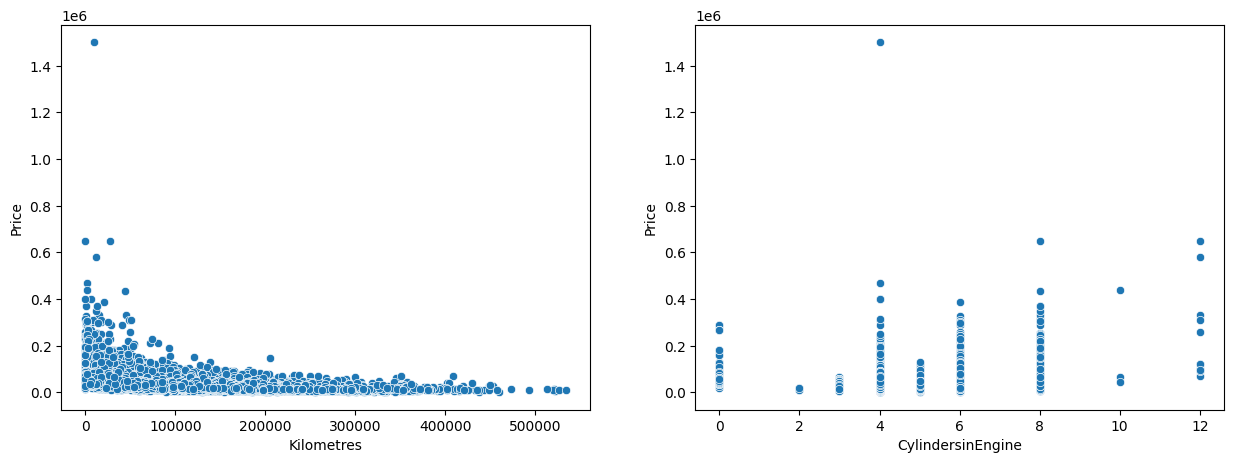

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.scatterplot(x=data_raw['Kilometres'], y=data_raw['Price'], ax=axs[0])
sns.scatterplot(x=data_raw['CylindersinEngine'], y=data_raw['Price'], ax=axs[1])

plt.show()

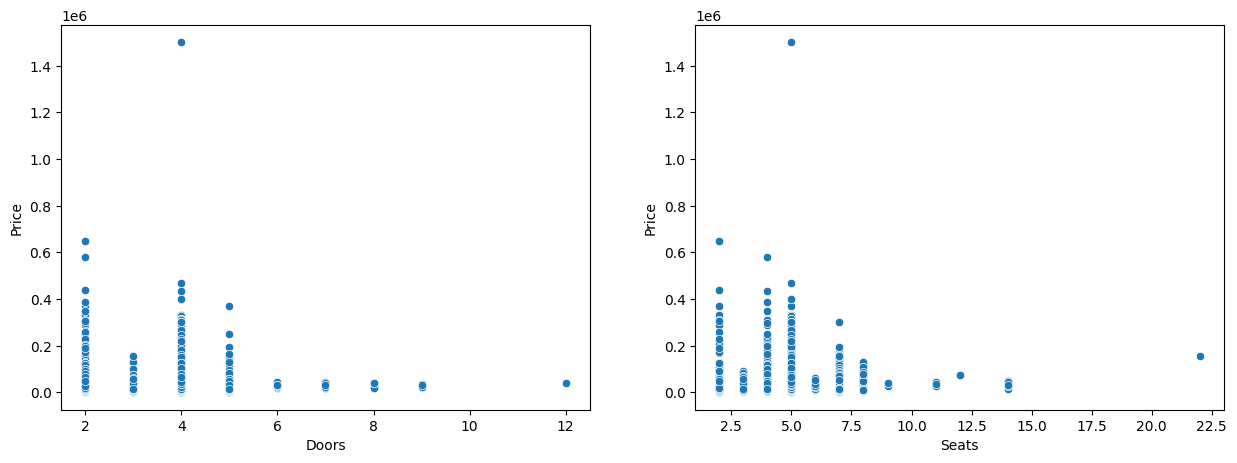

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.scatterplot(x=data_raw['Doors'], y=data_raw['Price'], ax=axs[0])
sns.scatterplot(x=data_raw['Seats'], y=data_raw['Price'], ax=axs[1])

plt.show()

In [61]:
categoriсal_columns = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType','FuelType', 'BodyType']

for columns in categoriсal_columns:
    print(columns, data_raw[columns].unique())
    print('\n')

Brand ['Ssangyong', 'MG', 'BMW', 'Mercedes-Benz', 'Renault', ..., 'Daewoo', 'Saab', 'Proton', 'Smart', 'Daihatsu']
Length: 66
Categories (66, object): ['Abarth', 'Alfa', 'Aston', 'Audi', ..., 'Tesla', 'Toyota', 'Volkswagen',
                          'Volvo']


UsedOrNew ['DEMO', 'USED', 'NEW']
Categories (3, object): ['DEMO', 'NEW', 'USED']


Transmission ['Automatic', 'Manual']
Categories (2, object): ['Automatic', 'Manual']


DriveType ['AWD', 'Front', 'Rear', 'Other', '4WD']
Categories (5, object): ['4WD', 'AWD', 'Front', 'Other', 'Rear']


FuelType ['Diesel', 'Premium', 'Unleaded', 'Hybrid', 'Other', 'Electric', 'LPG', 'Leaded']
Categories (8, object): ['Diesel', 'Electric', 'Hybrid', 'LPG', 'Leaded', 'Other', 'Premium',
                         'Unleaded']


BodyType ['SUV', 'Hatchback', 'Coupe', 'Commercial', 'Ute / Tray', 'Sedan', 'Wagon', 'People Mover', 'Convertible', 'Other']
Categories (10, object): ['Commercial', 'Convertible', 'Coupe', 'Hatchback', ..., 'SUV', 'Sedan',
  

# Матрица корреляций

<Axes: >

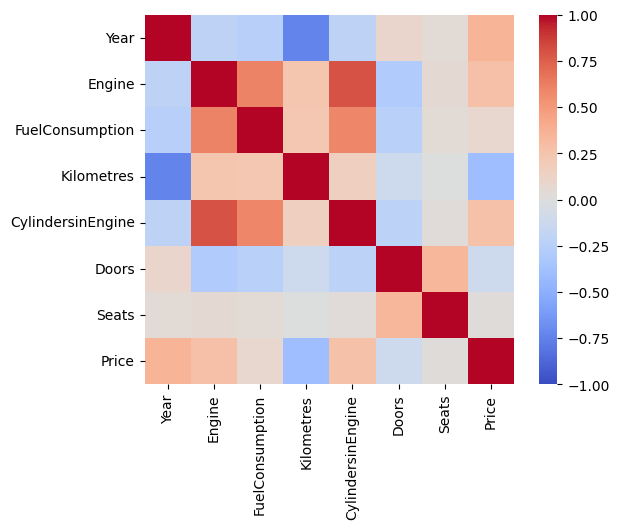

In [62]:
corr_mat = data_raw.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, vmin=-1, vmax=1, cmap='coolwarm')

Можем заметить что, сильно коррелируют:  
* пробег автомобиля и год выпуска    
* кол-во цилиндров в двигателе и потребление топлива
* тип дивгателля и потребление толива


In [63]:
numerical_columns = ['Year', 'Engine', 'FuelConsumption', 'Kilometres', 'CylindersinEngine', 'Doors', 'Seats', 'Price']
categorical_columns = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType','FuelType', 'BodyType']

# Label Encoding для категориальных признаков
label_encoder = LabelEncoder()
label_encoded_df = data_raw[categorical_columns].apply(label_encoder.fit_transform)

# Замена категориальных признаков на закодированные значения
data_raw[categorical_columns] = label_encoded_df


In [64]:
# Выбор числовых признаков для нормализации
numerical_columns = ['Year', 'Engine', 'FuelConsumption', 'Kilometres', 'CylindersinEngine', 'Doors', 'Seats', 'Price']
standard_scaler = StandardScaler()
data_raw[numerical_columns] = standard_scaler.fit_transform(data_raw[numerical_columns])

data_raw

,Brand,Year,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,CylindersinEngine,BodyType,Doors,Seats,Price
0,58,1.196481,0,0,-0.258531,1,0,0.445994,-1.224701,-0.373320,6,-0.037297,1.786313,0.531064
1,38,1.196481,2,0,-1.095696,2,6,-0.489587,-1.296100,-0.373320,3,1.453229,-0.108244,-0.473400
2,4,1.196481,2,0,-0.497721,4,6,-0.536366,-1.187881,-0.373320,2,-3.018350,-1.055523,2.320203
3,43,-1.006495,2,0,3.688102,4,6,1.521913,0.450829,3.357075,2,-3.018350,-1.055523,-0.065336
4,52,1.196481,2,0,-1.334886,2,7,-0.817040,-1.283059,-0.373320,6,-0.037297,-0.108244,-0.002557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16728,46,0.996210,2,0,-0.497721,2,7,-0.396029,-0.874268,-0.373320,6,-0.037297,-0.108244,0.053316
16729,63,-0.405683,2,0,0.000000,2,7,0.000000,-0.451642,-0.373320,0,4.434282,-0.108244,-0.174886
16731,60,1.196481,0,0,-0.976101,2,7,-0.723482,-1.230204,-0.373320,6,-0.037297,-0.108244,0.006546
16732,43,-0.005142,2,0,-0.497721,1,6,-0.255691,-0.201763,-0.373320,6,-0.037297,-0.108244,0.213967


Избавляемся от выбросов

In [65]:
def remove_outliers(df, target_column):

    data_cleaned = df.copy()
    categorical_features = ['Brand', 'UsedOrNew', 'Transmission', 'DriveType','FuelType', 'BodyType']

    for column in df.columns:
        if ((column == target_column)):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Определение границ выбросов
            lower_bound = Q1 - 1.5* IQR
            upper_bound = Q3 + 1.5* IQR

            # Удаление строк с выбросами
            data_cleaned = data_cleaned[(data_cleaned[column] >= lower_bound) & (data_cleaned[column] <= upper_bound)]

    return data_cleaned

# Выделение строк без выбросов
data_cleaned = remove_outliers(data_raw, 'Price')
data_cleaned.shape

(14482, 14)

# Разделение данных на обучающую и тестовую выборки

In [66]:
X = data_cleaned.drop('Price', axis=1)
y= data_cleaned['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Вывод результатов
print(X_train.shape, X_test.shape)

(10861, 13) (3621, 13)


#Метод K ближайших соседей (KNN)

In [67]:
# Импорт библиотек
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Определение гиперпараметров для KNN
param = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],  # Количество соседей
    'weights': ['uniform', 'distance'],  # Веса: равномерные или по расстоянию
    'p': [1, 2]  # Параметр расстояния
}


knn_regressor = KNeighborsRegressor()

# Поиск оптимальных гиперпараметровV
grid_search = GridSearchCV(knn_regressor, param, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("\nОптимальные гиперпараметры для KNN:", best_params)

# Создание модели KNN с оптимальными гиперпараметрами
knn_regressor_best = KNeighborsRegressor(**best_params)

# Обучение модели
knn_regressor_best.fit(X_train, y_train)

# Предсказание на обучающей выборке
y_train_pred_knn = knn_regressor_best.predict(X_train)

# Оценка модели на обучающей выборке
mse_train_knn = mean_squared_error(y_train, y_train_pred_knn)
r2_train_knn = r2_score(y_train, y_train_pred_knn)

# Вывод результатов на обучающей выборке
print("\nРезультаты модели KNN на обучающей выборке:")
print("Метрика (R^2) на обучающей выборке:", r2_train_knn)

# Предсказание на тестовой выборке
y_test_pred_knn = knn_regressor_best.predict(X_test)

# Оценка модели на тестовой выборке
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)
r2_test_knn = r2_score(y_test, y_test_pred_knn)

# Вывод результатов на тестовой выборке
print("\nРезультаты модели KNN на тестовой выборке:")
print("Метрика (R^2) на тестовой выборке:", r2_test_knn)




Оптимальные гиперпараметры для KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

Результаты модели KNN на обучающей выборке:
Метрика (R^2) на обучающей выборке: 0.9996292203526105

Результаты модели KNN на тестовой выборке:
Метрика (R^2) на тестовой выборке: 0.8746082198425498
